# Structural virality replication
Date: 1/27/2021

Author: Matthew Sun

**N.B.** This has only been thoroughly tested on the `sparse-matrix-imp` branch of `trecs` as of 2/18/2021. Use with caution!

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import os
import datetime
from collections import defaultdict

import trecs
from trecs.models import BassModel
from trecs.random import SocialGraphGenerator

# custom utilities
from graph_utils import (
    calc_avg_degree, 
    implied_beta, 
    scale_free_graph, 
    setup_experiment,
    popularity,
    prob_large_cascade,
    mean_virality,
    size_virality_corr
)

from create_graphs import (
    destringify_r,
    destringify_alpha
)

In [2]:
G = scale_free_graph(1000, alpha=2.3)
k = calc_avg_degree(G)
print(f"Average degree (k): {k}")
r = 0.5 # if r = 0.5, what is the beta implied?
print(f"Implied infectiousness when r={r}: {implied_beta(k,r)}")

Average degree (k): 33.844
Implied infectiousness when r=0.5: 0.014773667415199148


Text(0.5, 1.0, 'Frequency of out-degree for nodes in scale-free network')

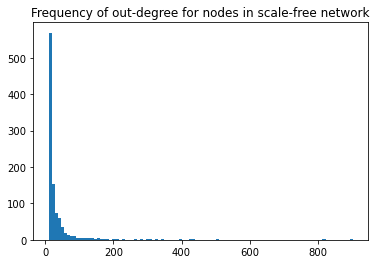

In [3]:
# plot degrees of nodes
degrees = [deg for n, deg in G.in_degree()]
plt.hist(degrees, bins=100)
plt.title("Frequency of out-degree for nodes in scale-free network")

Text(0.5, 1.0, 'Frequency of in-degree for nodes in scale-free network')

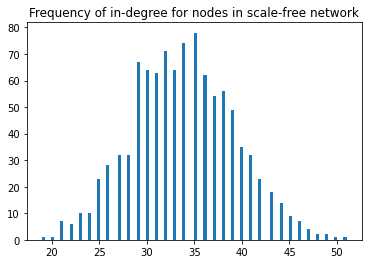

In [4]:
# plot degrees of nodes
degrees = [deg for n, deg in G.out_degree()]
plt.hist(degrees, bins=100)
plt.title("Frequency of in-degree for nodes in scale-free network")

In [5]:
def graph_popularity(sizes):
    plt.hist(sizes, bins=100)
    plt.title("Frequency of cascade sizes")
    plt.xlabel("Size")
    plt.ylabel("Frequency")

# Load experimental results

## Experimental procedure:
- Run `create_graphs.py`. Make sure to modify the constants in the main function to generate correct # of graphs with the correct # of nodes and with the right values for $\alpha$. This will create a new folder with graphs inside.
- Run `run_sim.py`. Alter the constants at the top to make sure it reads the right graphs from your graph directory. Also, specify how many simulations should be run per graph. This file will save the results of the simulations in the filename specified.
- Open this notebook to analyze the experimental results!

## Details for existing experimental files
- `sv_sims_10k_nodes.pkl` : 50 distinct graphs for each level of $\alpha$ (2.1, 2.3, 2.5, 2.7, 2.9), with 200 simulations performed graph & level of alpha, resulting in a total of 10,000 simulations per level of ($\alpha$, r). These graphs are currently stored on `mdsun@wash.cs.princeton.edu:~recsys/t-recs-experiments/structural_virality/graphs_10k`.
- `graphs_1m_batch_sim` : experiment performed on graphs of 1M nodes, with 1250 simulations per level of ($\alpha$, r). We performed 50 simulations per graph on 25 distinct graphs per level of ($\alpha$, r).
- `graphs_1m_batch_100` : experiment performed on graphs of 1M nodes, with 2500 simulations per level of ($\alpha$, r). We performed 100 simulations per graph on 25 distinct graphs per level of ($\alpha$, r).
- `graphs_1m_batch_200k` : experiment performed on graphs of 1M nodes, with 5000 simulations per level of ($\alpha$, r). We performed 200 simulations per graph on 25 distinct graphs per level of ($\alpha$, r).

In [6]:
f = open("sv_sims_10k_nodes.pkl", "rb")
results = pkl.load(f)
f.close()

In [7]:
def extract_alpha_rs(results_dict):
    """ Result the alpha and rs for the results dictionary.
    """
    alpha_set = set()
    r_set = set()
    for alpha, r in results_dict.keys():
        alpha_set.add(alpha)
        r_set.add(r)
    return sorted(list(alpha_set)), sorted(list(r_set))

In [8]:
alphas, rs = extract_alpha_rs(results)

In [9]:
# graphing
colors=['red', 'orange', 'green', 'blue', 'purple']

In [10]:
def plot_popularity_chance(results, alphas, rs):
    popularity_chance = {} # map from alpha to list, where each element corresponds to one R value
    for i, alpha in enumerate(alphas):
        popularity_chance[alpha] = [prob_large_cascade(results[(alpha, r)]["size"]) * 100 for r in rs]
        plt.plot(rs, popularity_chance[alpha], label=f"alpha={alpha}", color=colors[i])
    leg = plt.legend()
    plt.xlabel("r")
    plt.ylabel("Probability of popularity (%)")

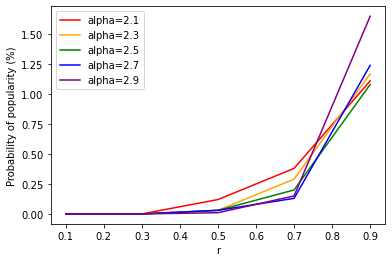

In [11]:
plot_popularity_chance(results, alphas, rs)

In [12]:
def plot_avg_virality(results, alphas, rs, pop_mask=False):
    avg_virality = {} # map from alpha to list, where each element corresponds to one R value
    for i, alpha in enumerate(alphas):
        avg_virality[alpha] = []
        for r in rs:
            if pop_mask:
                popular_mask = results[(alpha, r)]["size"] >= 100 # restrict graph to popular cascades
                avg_virality[alpha].append(mean_virality(results[(alpha, r)]["virality"], popular_mask=popular_mask))
            else:
                avg_virality[alpha].append(mean_virality(results[(alpha, r)]["virality"]))
        plt.plot(rs, avg_virality[alpha], label=f"alpha={alpha}", color=colors[i])
    plt.legend()
    plt.xlabel("r")
    plt.ylabel("Mean structural virality")

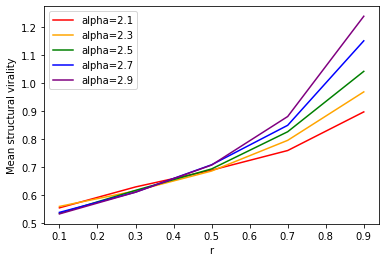

In [13]:
plot_avg_virality(results, alphas, rs)

In [14]:
def plot_size_vir_corr(results, alphas, rs):
    size_vir_corr = {} # map from alpha to list, where each element corresponds to one R value
    for i, alpha in enumerate(alphas):
        size_vir_corr[alpha] = [size_virality_corr(results[(alpha, r)]["size"], results[(alpha, r)]["virality"]) for r in rs]
        plt.plot(rs, size_vir_corr[alpha], label=f"alpha={alpha}",color=colors[i])
    plt.legend()
    plt.xlabel("r")
    plt.ylabel("Correlation between size and structural virality")

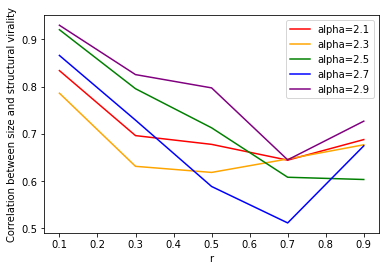

In [15]:
plot_size_vir_corr(results, alphas, rs)

### 1M node experiments

In [16]:
experiment_dir = "graphs_1m_batch_sim"

agg_results = defaultdict(lambda: defaultdict(list)) # holds results for entire simulation

# process experimental results for each graph and add to aggregate results
for (root,dirs,files) in os.walk(experiment_dir, topdown=True): 
    for f in files:
        if f == "sim_result.pkl":
            folders = os.path.normpath(root).split(os.path.sep)
            alpha, r = destringify_alpha(folders[-3]), destringify_r(folders[-2])
            result = pkl.load(open(os.path.join(root, f), "rb"))
            agg_results[(alpha, r)]["size"].append(result["size"])
            agg_results[(alpha, r)]["virality"].append(result["virality"])
            
for alpha_r in agg_results.keys():
    agg_results[alpha_r]["size"] = np.concatenate(agg_results[alpha_r]["size"])
    agg_results[alpha_r]["virality"] = np.concatenate(agg_results[alpha_r]["virality"])

In [17]:
alphas, rs = extract_alpha_rs(agg_results)

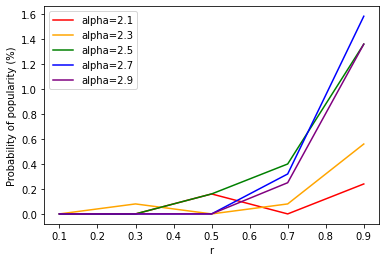

In [18]:
plot_popularity_chance(agg_results, alphas, rs)

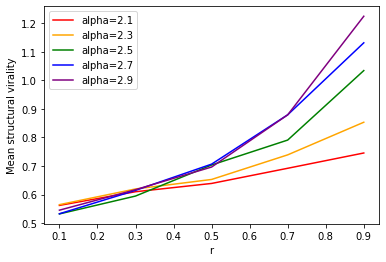

In [19]:
plot_avg_virality(agg_results, alphas, rs)

/mnt/c/Users/matth/pton-research/recsys/experiments/structural_virality/graph_utils.py:94: RuntimeWarning: Mean of empty slice.
  return popular_viralitys[popular_viralitys > -1].mean()
/home/mattsun/anaconda3/envs/trecs/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


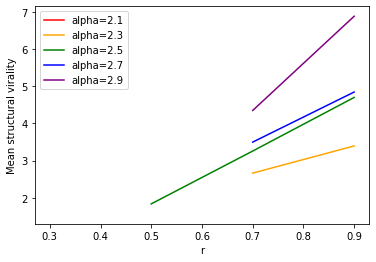

In [20]:
plot_avg_virality(agg_results, alphas, rs, pop_mask=True)

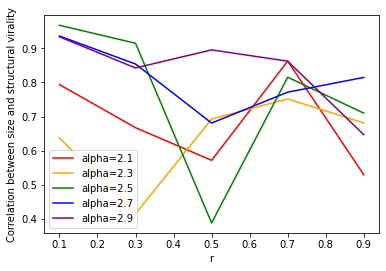

In [21]:
plot_size_vir_corr(agg_results, alphas, rs)